In [1]:
from kan import *
import pickle
import control as ct

In [2]:
with open('pendulum_variables_data.pkl', 'rb') as f:
    tf,dp,dt,nx,m,predict_time = pickle.load(f)

data_x = torch.load('data_x_c_noisy.pt')
train_x = data_x[0:20,:,:]
train_x = train_x.reshape([int(len(train_x)*(dp)),nx])
test_x = data_x[8:10,:,:]
test_x = test_x.reshape([int(len(test_x)*(dp)),nx])
data_y = torch.load('data_y_c_noisy.pt')
train_y = data_y[0:20,:,:]
train_y = train_y.reshape([int(len(train_y)*(dp)),nx])
test_y = data_y[8:10,:,:]
test_y = test_y.reshape([int(len(test_y)*(dp)),nx])
data_y2 = torch.load('data_y2_c_noisy.pt')
train_y2 = data_y2[0:20,:,:]
train_y2 = train_y2.reshape([int(len(train_y2)*(dp)),nx])
test_y2 = data_y2[8:10,:,:]
test_y2 = test_y2.reshape([int(len(test_y2)*(dp)),nx])
data_u = torch.load('data_u_c_noisy.pt')
train_u= data_u[0:20,:,:]
train_u = train_u.reshape([int(len(train_u)*(dp)),m])
test_u = data_u[8:10,:,:]
test_u = test_u.reshape([int(len(test_u)*(dp)),m])

dataset = {}
dataset['train_input'] = train_x
dataset['test_input'] = test_x
dataset['train_label'] = train_y
dataset['test_label'] = test_y

# ***Koopman Training***

In [5]:
lifted_space = 1
hidden_size = 1
learning_rate = 1
Loss_prev = 1e38
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1)
criterion = torch.nn.MSELoss()

log = 1

grids = [10]
steps = 3

recon_losses = []
pred_losses = []

for grid in grids:
    if grid == grids[0]:
        model = KAN(width=[nx,hidden_size,lifted_space], grid=grid, k=3, grid_eps=0, noise_scale_base=0.25)
    else:
        model = KAN(width=[nx,hidden_size,lifted_space], grid=grid, k=3).initialize_from_another_model(model, train_x)

    def train():
        optimizer = LBFGS(model.parameters(), lr=learning_rate, history_size=100, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
        pbar = tqdm(range(steps), desc='description')

        for step in pbar:
            def closure():
                global pred_loss, recon_loss, K, B
                optimizer.zero_grad()

                phi_k = torch.transpose(model(train_x),0,1)
                phi_k = torch.cat((torch.transpose(train_x,0,1),phi_k),0)
                phi_kp1 = torch.transpose(model(train_y),0,1)
                phi_kp1 = torch.cat((torch.transpose(train_y,0,1),phi_kp1),0)

                W = torch.cat((phi_k,torch.transpose(train_u,0,1)),0)  
                V = phi_kp1

                Vwt = torch.matmul(V,torch.transpose((W),0,1))
                Wwt = torch.matmul(W,torch.transpose((W),0,1))
                KB = torch.matmul(Vwt,torch.pinverse(Wwt))

                K = KB[:,0:-m]
                B = KB[:,-m:]

                # next time step prediciton with linear Koopman operator
                K_phi_plus_one = torch.matmul(K,phi_k)+torch.matmul(B,torch.transpose(train_u,0,1))
                x_plus_one = torch.transpose(torch.matmul(P,K_phi_plus_one),0,1)
                recon_loss = criterion(x_plus_one, train_y)
                
                for l in range(predict_time):
                    next_phi = torch.matmul(K,phi_k) + torch.matmul(B,torch.transpose(train_u,0,1)) # K: This is the linear operation. 
                    next_state = torch.transpose(torch.matmul(P,next_phi),0,1) # extracting the next state
                    next_state_encoded = model(next_state) # stacking original states on 
                    phi_k = torch.transpose(torch.cat((next_state,next_state_encoded),1),0,1)

                pred_loss = criterion(next_state, train_y2) # Koopman loss (finds K) EDMD loss

                l2 = torch.mean((x_plus_one - train_y)**2)

                loss = recon_loss + pred_loss
                loss.backward()
                return loss
            
            if step % 1 == 0 and step < 50:
                model.update_grid_from_samples(train_x)
                
            optimizer.step(closure)            

            if step % log == 0:
                pbar.set_description("reconstruction loss: %.2e | prediction loss: %.2e" % (recon_loss.cpu().detach().numpy(), pred_loss.cpu().detach().numpy()))

            recon_losses.append(recon_loss.detach().numpy())
            pred_losses.append(pred_loss.detach().numpy())
    train()

reconstruction loss: 7.60e-09 | prediction loss: 2.02e-06: 100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


Loss Plots

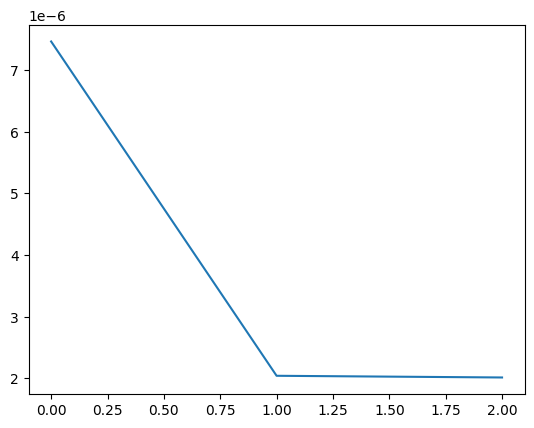

In [6]:
plt.plot(pred_losses)

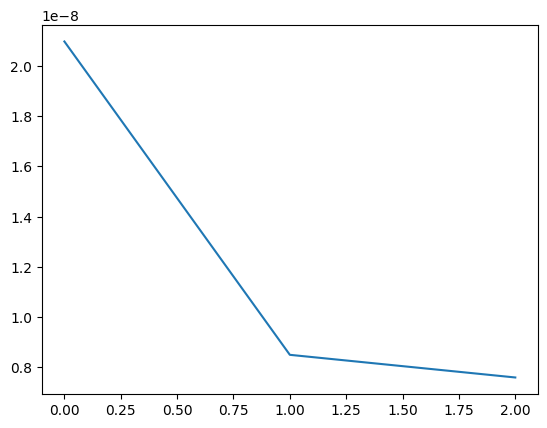

In [7]:
plt.plot(recon_losses)

In [8]:
# function to output the state space dynamics of the orbit
def pendfunc(t,x,u):
    g = 9.81  # gravity
    L = 5  # length     
    fdyn = np.array([x[1], -g*np.sin(x[0])/L+u[0]])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, uk, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk,uk, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)),uk, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)),uk, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt),uk, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

One Time-Step Prediction

Text(0.5, 1.0, '$\\dot{\\Theta}$')

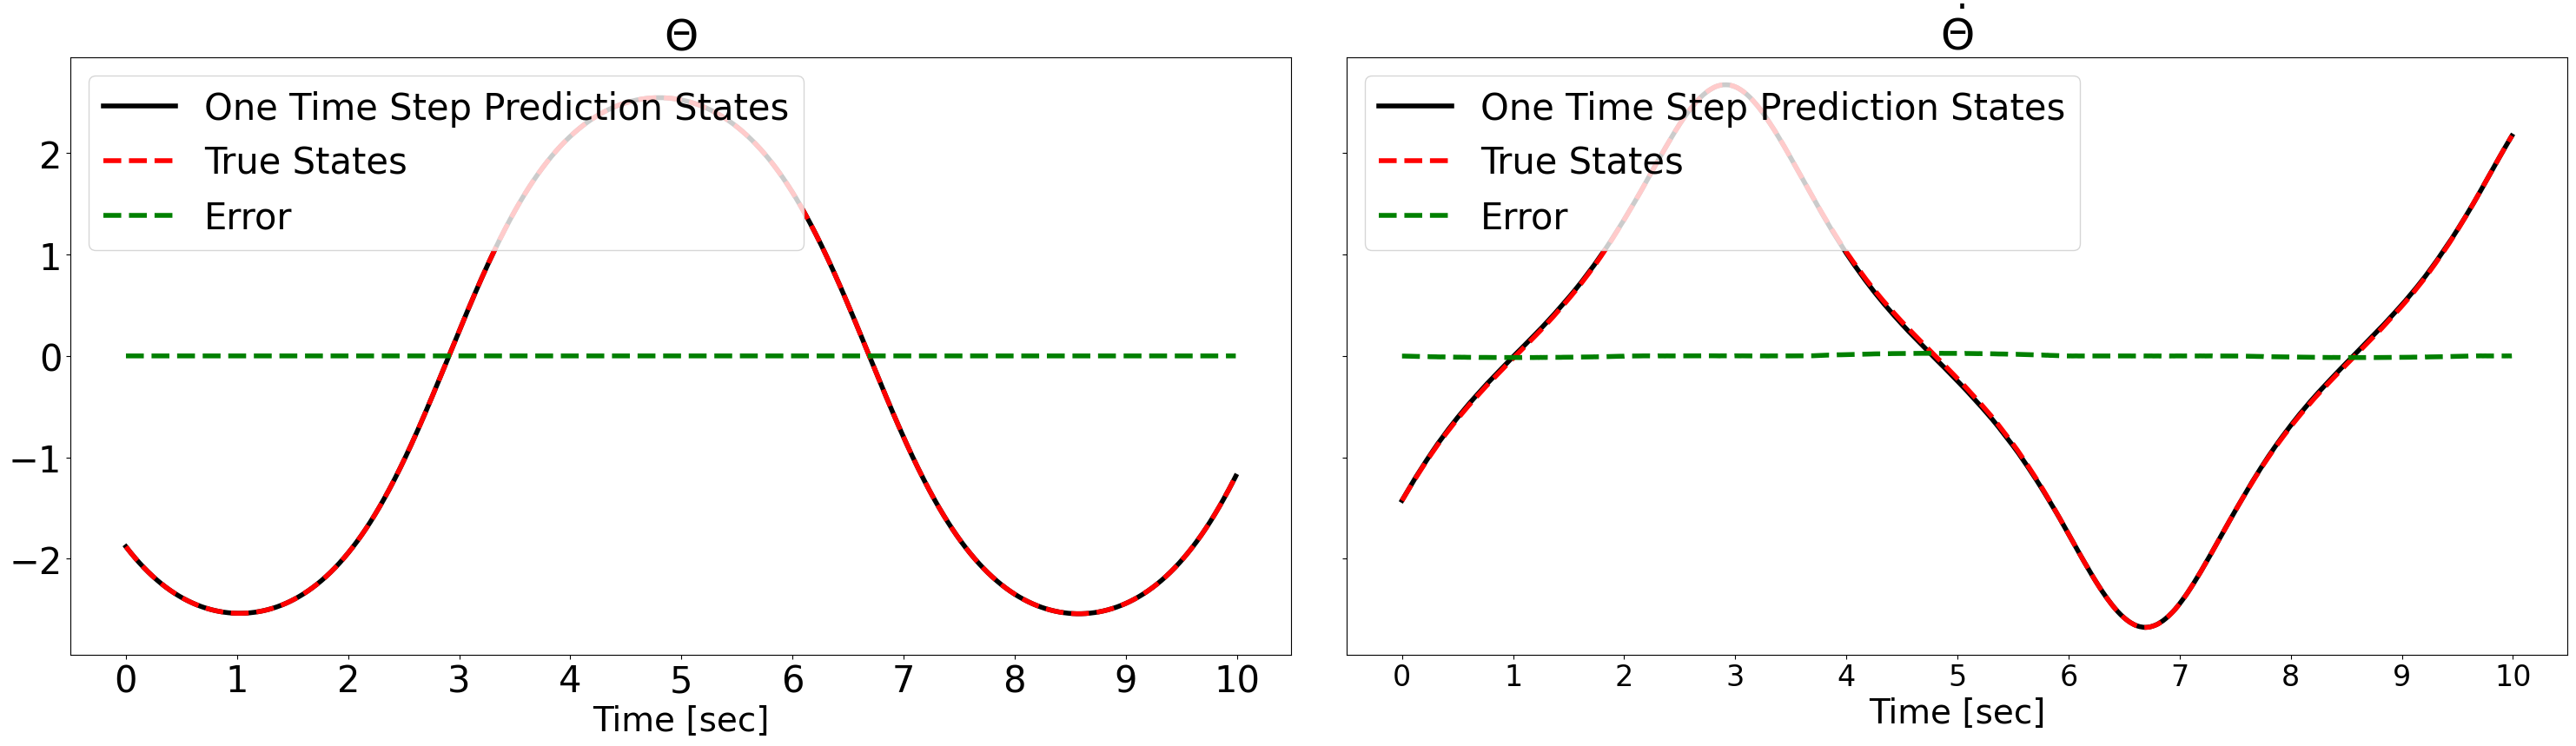

In [9]:
x_init=2*torch.Tensor(2).uniform_(-1, 1) # random initial condition
tf = 10 # simulation time
dp = int(tf/dt) # number of data points

time = np.linspace(0, tf, dp+1) # time vector
xk = x_init 
sol = np.empty([nx,]) # initializing matrix to hold solution

# Nonlinear solution from equations of motion
for t in time:
    uk = 0.05*torch.Tensor(1).uniform_(-1, 1)
    sol = np.vstack((sol, xk))
    xk = rk4(pendfunc, t, xk,uk, dt) # RK4 approximation of solution

# splitting nonlinear solution into current and next timestep
sol = torch.FloatTensor(sol)
newx = sol[1:-1,:]
newy = sol[2:,:]

# observables for current and next time step
new_phi = torch.transpose(model(newx),0,1)
new_phi = torch.cat((torch.transpose(newx,0,1),new_phi),0)
new_phi_p1 = torch.matmul(K,new_phi)

# Plotting results
kp1_plot = torch.transpose(newy,0,1)
fig, ax = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (30, 8))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red']
line = ['-', '--']
plot_lines = []
error = kp1_plot - new_phi_p1[0:2,:]
for i in range(2):
    p1, = ax[i].plot(new_phi_p1[i,:].detach(), color=colours[0], linestyle=line[0], label='One Time Step Prediction States', linewidth=4)
    p2, = ax[i].plot(kp1_plot[i,:].detach(), color=colours[1], linestyle=line[1], label='True States', linewidth=4)
    p3, = ax[i].plot(error[i,:].detach(), color='green', linestyle=line[1], label='Error', linewidth=4)
    ax[i].legend(loc=2, fontsize=30)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=24)
    ax[i].set_xlabel("Time [sec]", fontsize = 28)
#     plot_lines.append([p1, p2])
# legend1 = ax.legend(plot_lines[0], ['Exact Solution', 'Proposed Solution'], fontsize=30, loc=4)
# ax.add_artist(legend1)
# ax.legend([p[0] for p in plot_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax[0].set_ylabel('', fontsize = 22)
ax[0].tick_params(labelsize=30)
ax[0].set_title(r"$\Theta$", fontsize=36)
ax[1].set_title(r"$\dot{\Theta}$", fontsize=36)

Full Propagation Prediction

c:\Users\georg\Documents\University\FIT\Research\KAN Network\Pendulum\.venv\Lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


Text(0.5, 1.0, 'Error in Proposed Solution for $\\Theta$ and $\\dot{\\Theta}$')

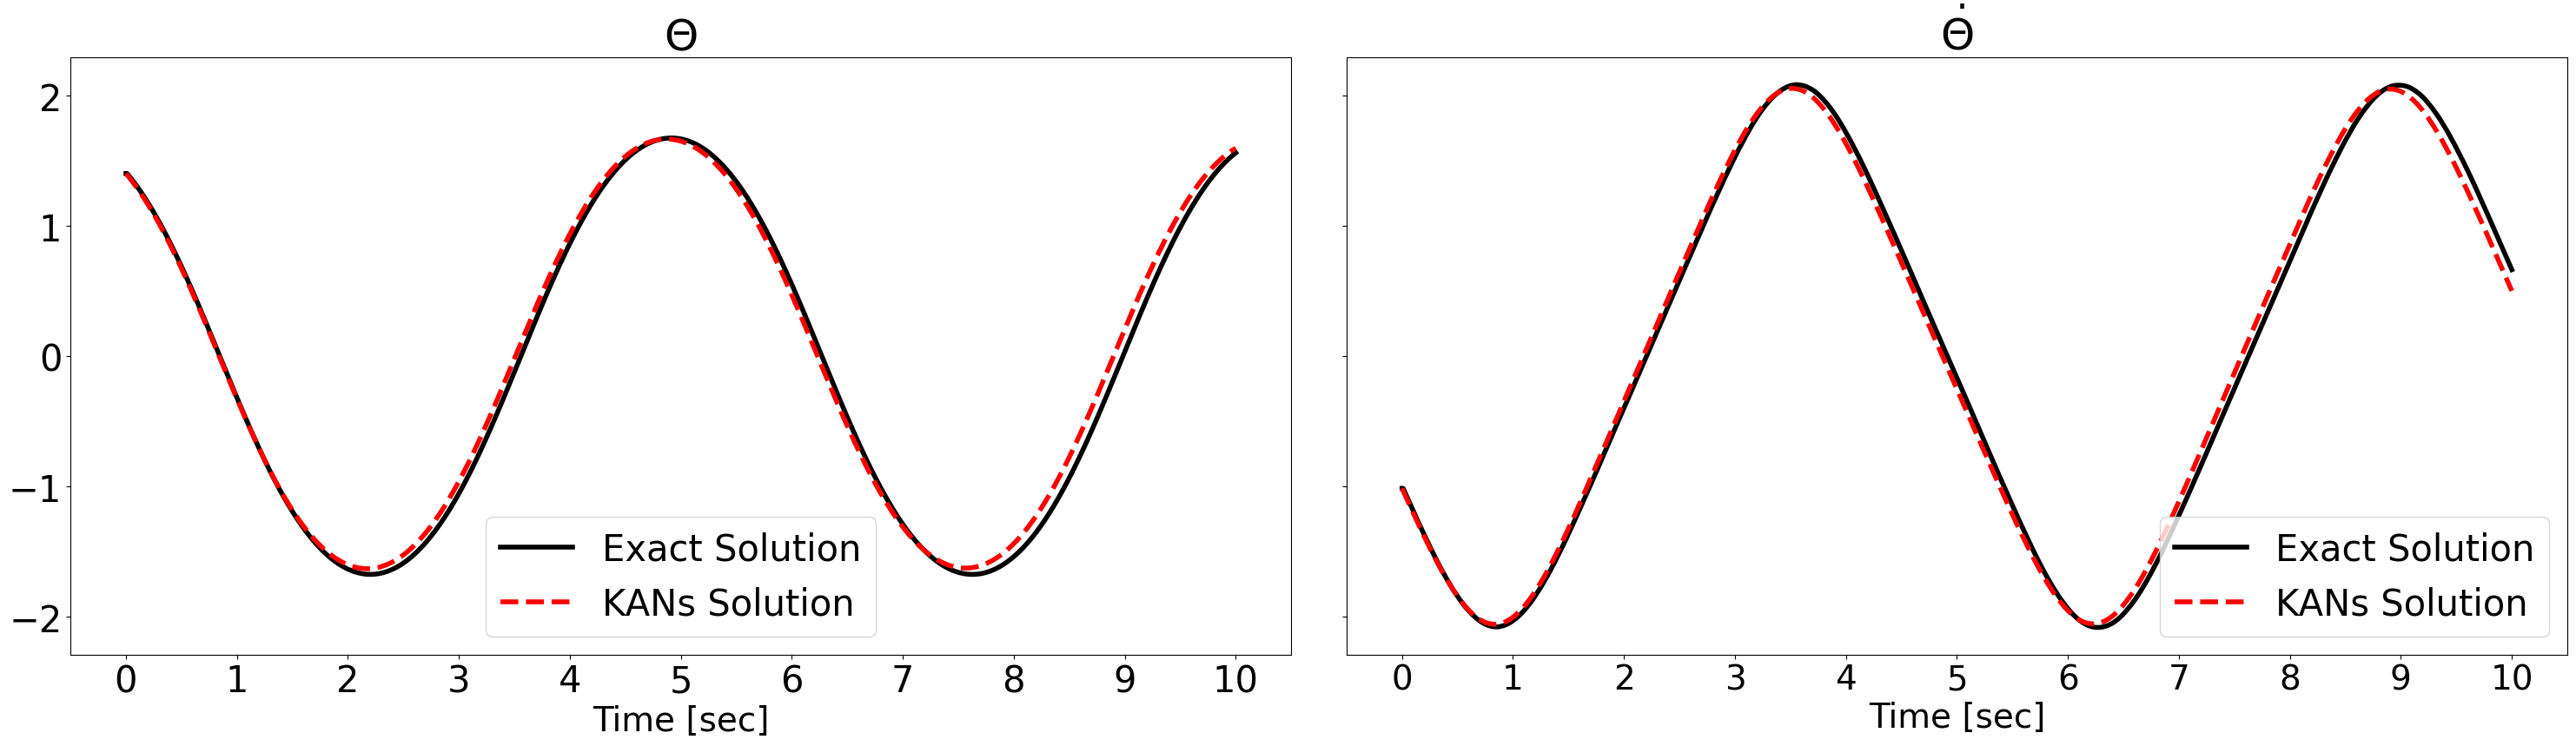

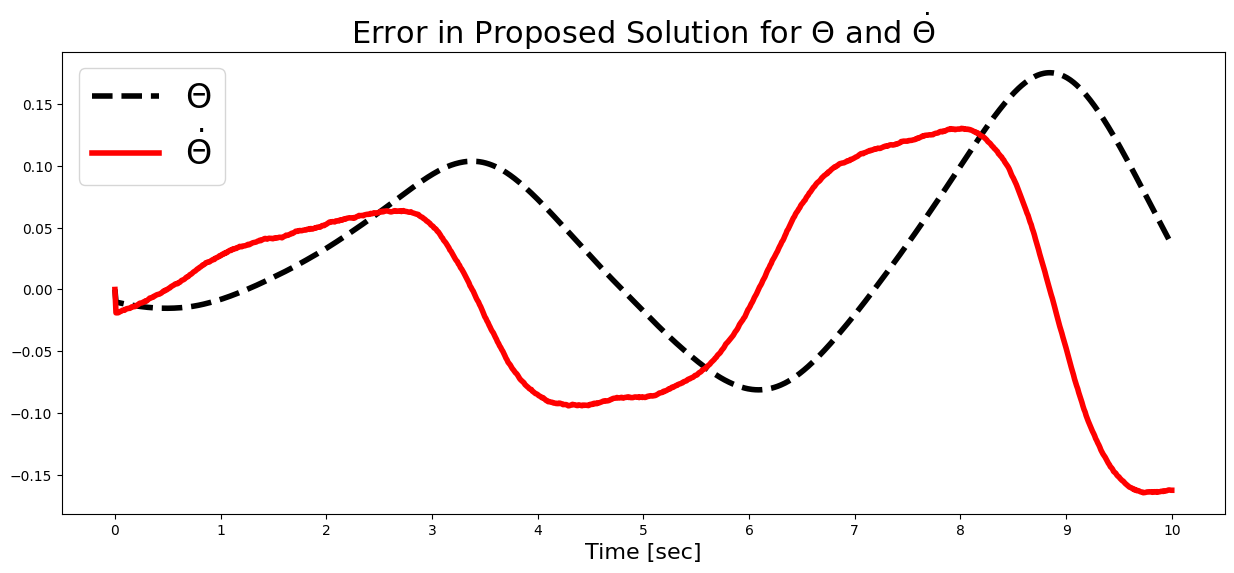

In [10]:
# x_init=2*torch.Tensor(1,2).uniform_(-1, 1)# + (0.001**0.5)*torch.rand(2) # random initial condition with noise
x_init = torch.tensor([[1.4021,-1.0130]]) # same initial condition as autoencoder model

# observable of the initial condition and stacking original states on observable
x_init_encoded = torch.transpose(model(x_init),0,1)
x_in = torch.cat((torch.transpose(x_init,0,1),x_init_encoded),0)

time = np.linspace(0,10,1000) # time vector

# initializing vectors
pred = torch.clone(torch.transpose(x_init,0,1))
save_u = np.empty([m,])
xk = torch.tensor([x_init[0,0], x_init[0,1]])
# sol = np.empty([nx,])
sol = np.copy(x_init)

# simulation
i = 0
for t in time:
    u_dt = 0.05*torch.Tensor(1,1).uniform_(-1, 1) # random control input
    save_u = np.vstack((save_u, u_dt)) # saving control history
    next_phi = torch.matmul(K,x_in) + torch.matmul(B,u_dt) # linear dynamics with Koopman matrices
    next_state = torch.matmul(P.cpu(),next_phi) # correction step
    next_state_encoded = torch.transpose(model(torch.transpose(next_state,0,1)),0,1) # lifting the next state for next iteration
    x_in = torch.cat((next_state,next_state_encoded),0) # stacking original state on observables
    pred = torch.hstack([pred, next_state]) # saving solution history
    i = i+1

    # nonlinear solution
    uk = u_dt[0]
    sol = np.vstack((sol, xk))
    xk = rk4(pendfunc, t, xk, uk, dt)

sol = torch.FloatTensor(sol)
exact = torch.transpose(sol,0,1)

# Plotting
fig, ax = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (30, 8))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
plot_lines = []
for i in range(2):
    p1, = ax[i].plot(exact[i,:].detach(), color=colours[0], linestyle=line[0], label='Exact Solution', linewidth=4)
    p2, = ax[i].plot(pred[i,:].detach(), color=colours[1], linestyle=line[1], label='KANs Solution', linewidth=4)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=28)
    ax[i].set_xlabel("Time [sec]", fontsize = 28)
    ax[i].legend(fontsize=30)
    # plot_lines.append([p1, p2])
# legend1 = ax.legend(plot_lines[0], ['Exact Solution', 'RLDK Solution'], fontsize=30, loc=4)
# ax.add_artist(legend1)
# ax.legend([p[0] for p in plot_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax[0].set_ylabel('', fontsize = 22)
ax[0].tick_params(labelsize=30)
ax[0].set_title(r"$\Theta$", fontsize=36)
ax[1].set_title(r"$\dot{\Theta}$", fontsize=36)

error = pred - exact

# Plotting error
plt.figure(figsize = (15, 6))
ax = plt.axes()
colours = ['black', 'red','deepskyblue']
line = ['--','-']
labels = [r'$\Theta$', r'$\dot{\Theta}$']
for i in range(2):
    ax.plot(error[i,:].detach(), color=colours[i], linestyle=line[i], label=labels[i], linewidth=4)
    ax.legend(fontsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Time [sec]", fontsize=16)
plt.title(r"Error in Proposed Solution for $\Theta$ and $\dot{\Theta}$", fontsize=22)

# ***LQR Controller Development***

In [11]:
A = (K-torch.eye(lifted_space+nx))/dt
A_lqr = A.detach().numpy()
B_lqr = (B/dt).detach().numpy()


Q = np.eye(lifted_space+nx)
Q[0,0] = 10
Q[1,1] = 10
Q[2,2] = 0
# Q[3,3] = 0
R = 1

K_lqr,S,E = ct.lqr(A_lqr,B_lqr,Q,R)
K_lqr = torch.FloatTensor(K_lqr)
A_lqr = torch.FloatTensor(A_lqr)
B_lqr = torch.FloatTensor(B_lqr)

c:\Users\georg\Documents\University\FIT\Research\KAN Network\Pendulum\.venv\Lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


Text(0.5, 1.0, 'LQR Response with KANs model')

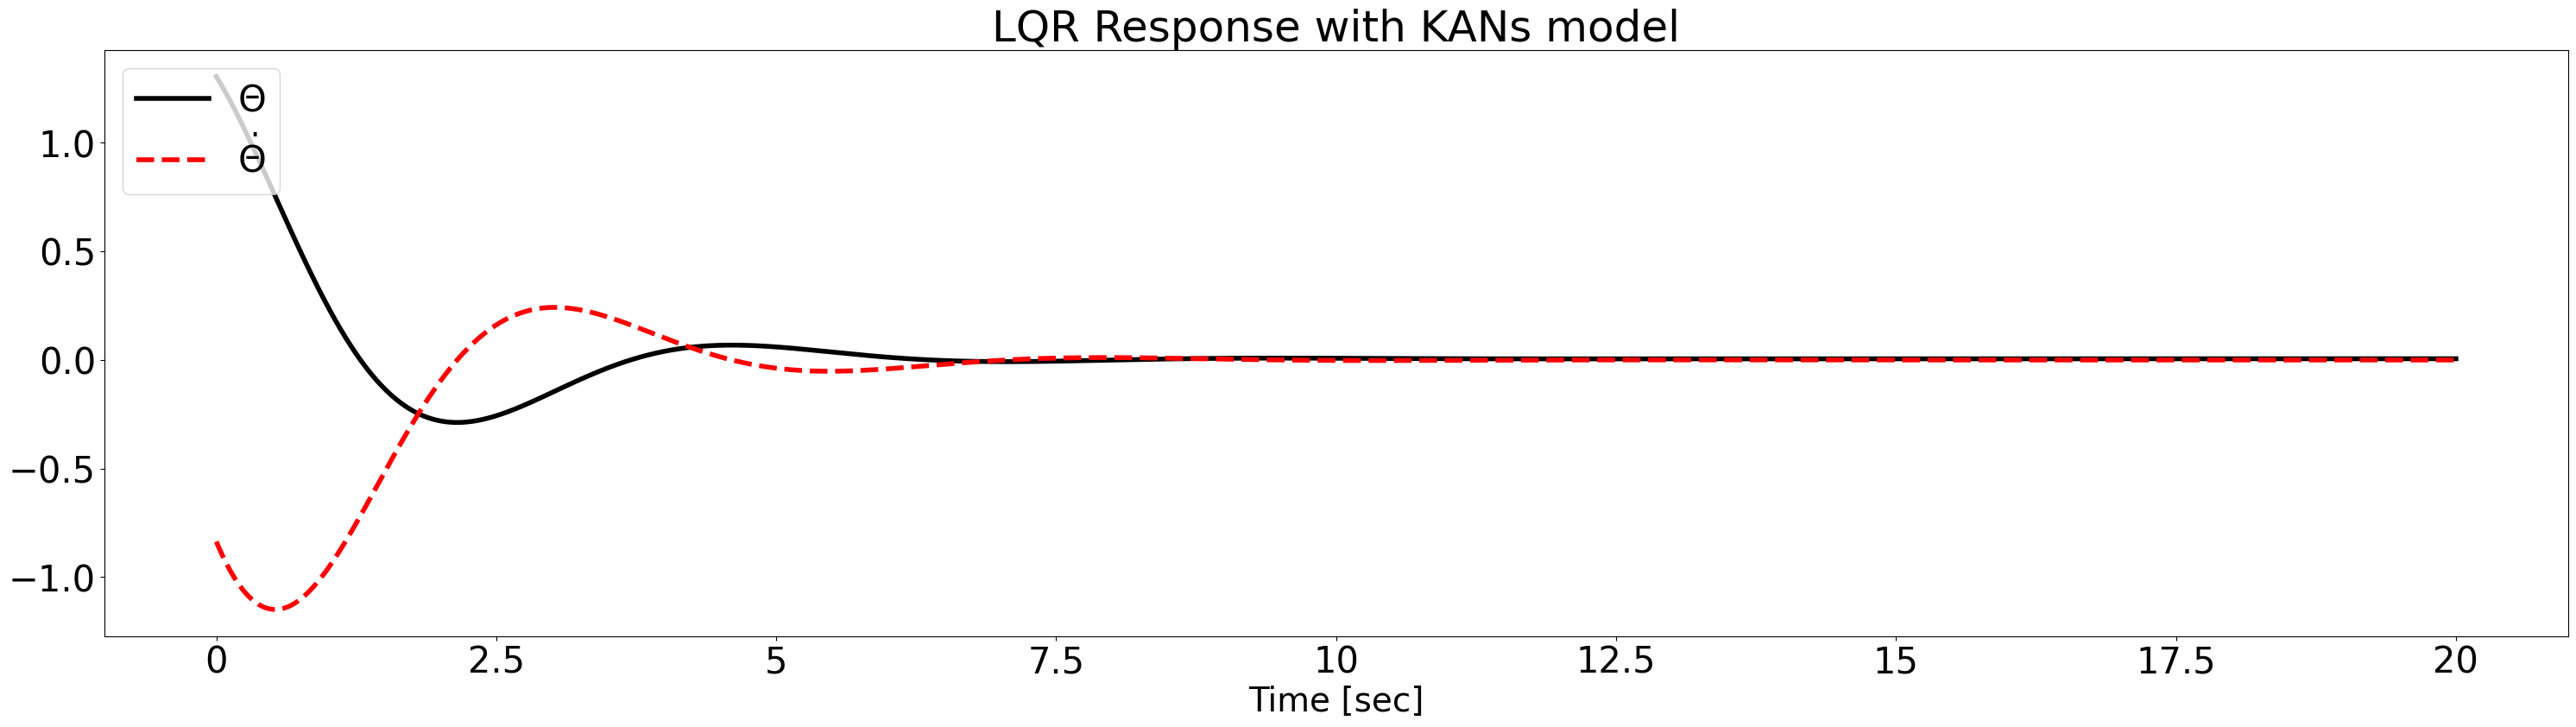

In [13]:
x_init=2*torch.Tensor(1,2).uniform_(-1, 1)# + (0.001**0.5)*torch.rand(2) # random initial condition with noise
x_init_encoded = torch.transpose(model(x_init),0,1)
x_in = torch.cat((torch.transpose(x_init,0,1),x_init_encoded),0)

time = np.linspace(0,20,2000) # time vector

# initializing vectors
pred = torch.clone(torch.transpose(x_init,0,1))
save_u = np.empty([m,])
xk = torch.tensor([x_init[0,0], x_init[0,1]])

# simulation
i = 0
for t in time:
    u_dt = -torch.matmul(K_lqr,x_in).detach() # random control input
    save_u = np.vstack((save_u, u_dt)) # saving control history
    next_phi = torch.matmul(K,x_in) + torch.matmul(B,u_dt) # linear dynamics with Koopman matrices
    next_state = torch.matmul(P.cpu(),next_phi) # correction step
    next_state_encoded = torch.transpose(model(torch.transpose(next_state,0,1)),0,1) # lifting the next state for next iteration
    x_in = torch.cat((next_state,next_state_encoded),0) # stacking original state on observables
    pred = torch.hstack([pred, next_state]) # saving solution history
    i = i+1

# Plotting
fig = plt.figure(figsize = (30, 8))
ax = plt.axes()
fig.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
plot_lines = []
for i in range(2):
    p1, = ax.plot(pred[i,:].detach(), color=colours[i], linestyle=line[i], label='RLDK Solution', linewidth=4)
    ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000], [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20], fontsize=28)
ax.set_xlabel("Time [sec]", fontsize = 28)
ax.legend([r'$\Theta$', r'$\dot{\Theta}$'], loc=2, fontsize=30)
ax.set_ylabel('', fontsize = 22)
ax.tick_params(labelsize=30)
ax.set_title(r"LQR Response with KANs model", fontsize=36)

Numbers of Parameters

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

59